# Brief frequentist inference refresh!

- Create a random variable with mean 5 and standard deviation 1.5, size 10k
- Create 1000 random samples of 100 elements (without replacement)
- Plot sampling distribution
- Estimate standard errors 
- Estimate and plot confidence intervals

# Libraries

In [36]:
library(data.table)
library(ggplot2)

# Some formulas

### Mean

$\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i$ 

###  Standard deviation

$\sigma =\sqrt{\frac{\sum (x_i-\mu)^2}{n-1}}$

### Standard error 

$SE = \frac{\sigma}{\sqrt{n}}$


# Creating a fake normal variable

In [37]:
set.seed(123)
options(repr.plot.width=8, repr.plot.height=8)

y = rnorm(10000, 5, 1.5)
summary(y)
print(paste0('Standard deviation: ', round(sd(y), 3)))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -0.768   3.998   4.983   4.996   6.010  10.772 

[1] "Standard deviation: 1.498"


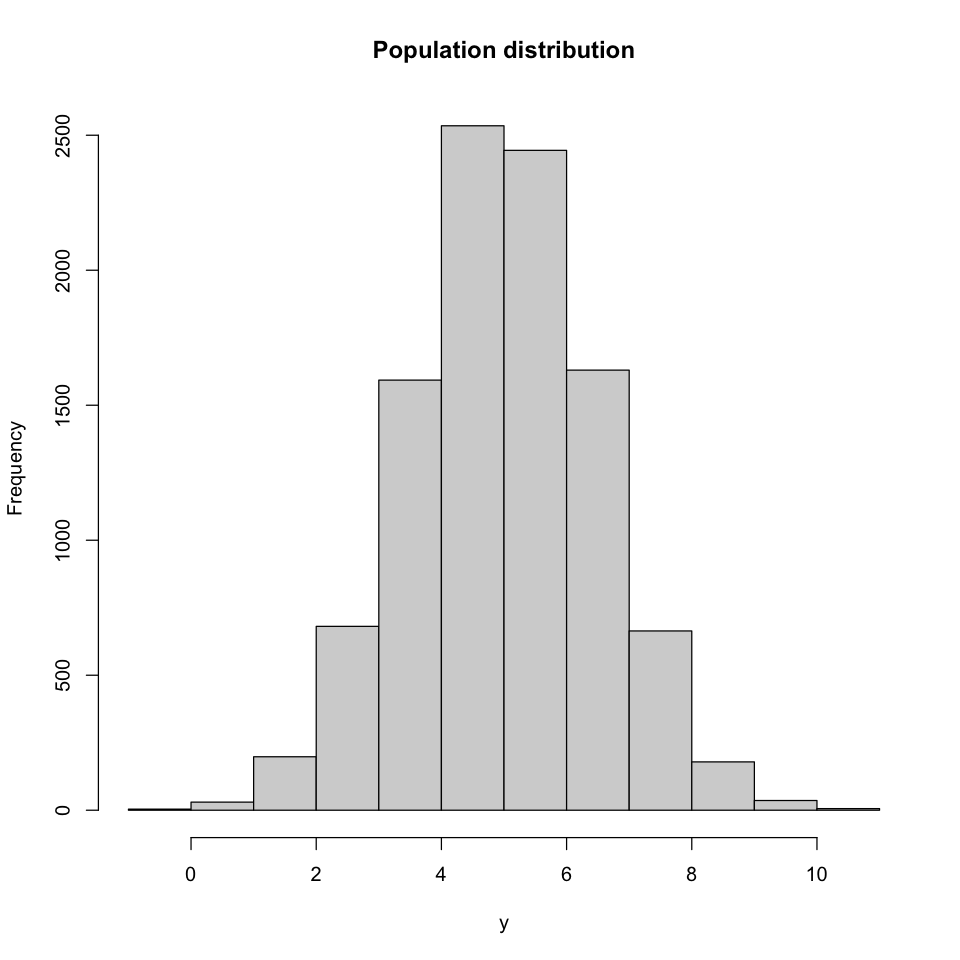

In [38]:
hist(y, main='Population distribution')

## Run multiple samples (cloud of potential values)

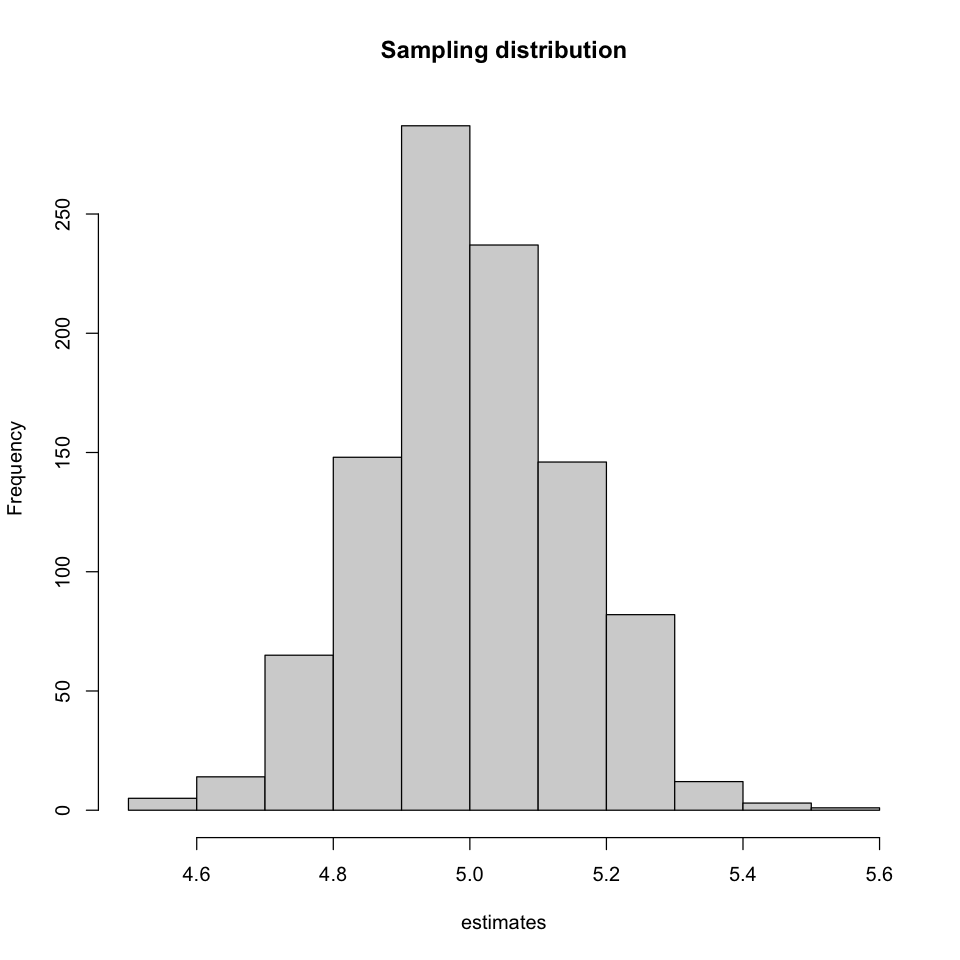

In [39]:
estimates = NULL
samples = list()
for (i in 1:1000) {
    samples[[i]] = sample(y, 100)
    estimates = c(estimates, mean(samples[[i]]))
}
hist(estimates, main = 'Sampling distribution')

In [40]:
createSamples = function(nsamples=1000, samplesize=100, population, seed=123) {

    set.seed(seed)
    estimates = NULL
    samples = list()
    for (i in 1:nsamples) {
        samples[[i]] = sample(population, samplesize)
        estimates = c(estimates, mean(samples[[i]]))
    }
    return(list('estimates'=estimates, 'samples'=samples))
}

results = createSamples(population=y)

In [41]:
length(results)

[1] 2

In [42]:
summary(results$estimates)
print(paste0('Standard error from sampling distribution: ', round(sd(results$estimates), 3)))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  4.535   4.896   5.006   5.001   5.105   5.462 

[1] "Standard error from sampling distribution: 0.148"


## Let's now look just to one sample, what we would get in reality

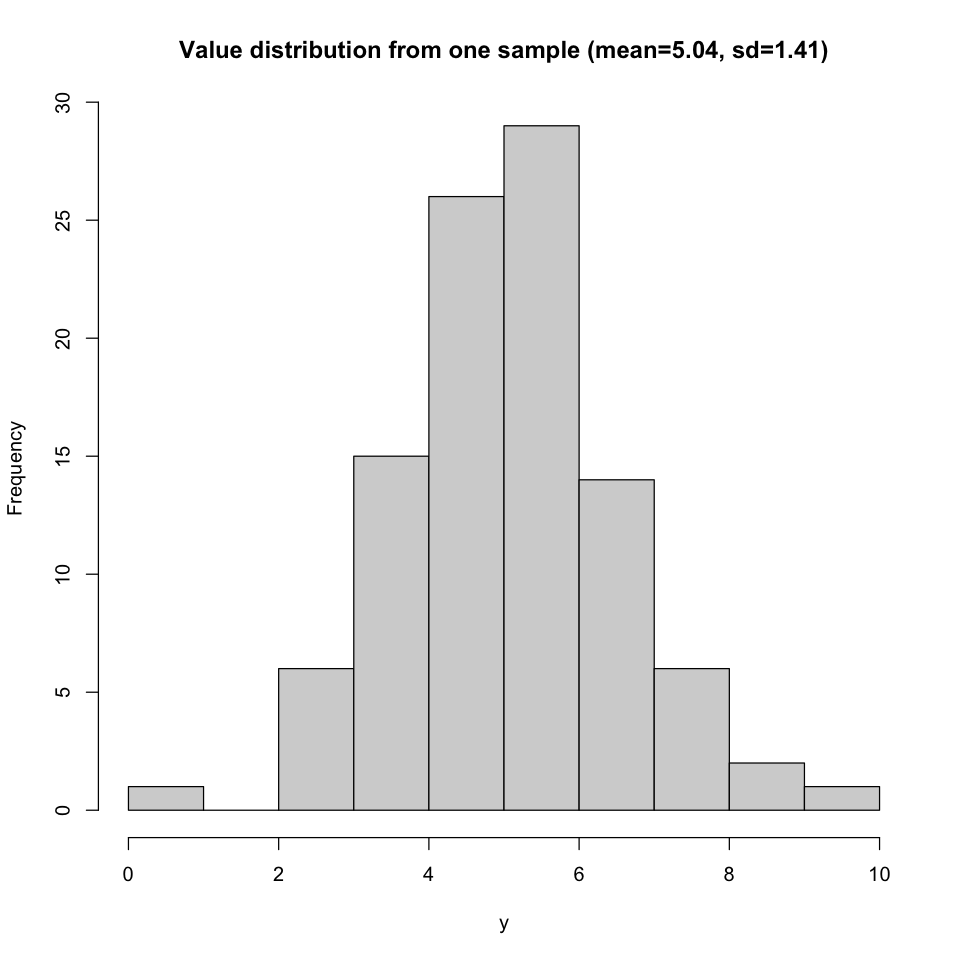

In [43]:
example = results[['samples']][[3]]
hist(example, 
    main=paste0('Value distribution from one sample (mean=', round(mean(example), 2), ', sd=', round(sd(example), 2), ')'), 
    xlab='y', breaks=6)

## Compute the standard error from a sample


In [44]:
se = sd(example) / sqrt(length(example))
print(paste0('Standard error: ', round(se, 3)))

[1] "Standard error: 0.141"


## Let's get a confidence interval (CI) with 95% of confidence

- Margin of error (MOE)


$MOE= z * \sqrt{\frac{\sigma^2}{n}}$

$MOE= z * SE$

In [45]:
z = qnorm(0.975)
print(paste0('z-score: ', round(z, 3)))

moe = z * se
print(paste0('CI: [', round(mean(example) - moe, 4), ' ; ', round(mean(example) + moe, 4), ']'))
print(paste0('Point estimate: ', round(mean(example), 3)))

[1] "z-score: 1.96"
[1] "CI: [4.7669 ; 5.32]"
[1] "Point estimate: 5.043"


In [46]:
# let's compute the CI for all samples
dt = data.table()
for (i in seq_along(results[['samples']])) {
    temp = results[['samples']][[i]]
    se = sd(temp) / sqrt(length(temp))
    moe = z * se
    temp = data.table(y=mean(temp), se=se, moe=moe, 
        lower=mean(temp) - moe, upper=mean(temp) + moe)
    dt = rbind(dt, temp)
}

setorder(dt, y)
dt[, seq := 1:.N]
dt[, include_true_value := factor(ifelse(lower < mean(y) & upper > mean(y), 1, 0), labels=c('no', 'yes'))]
prop.table(table(dt$include_true_value))


  no  yes 
0.04 0.96 

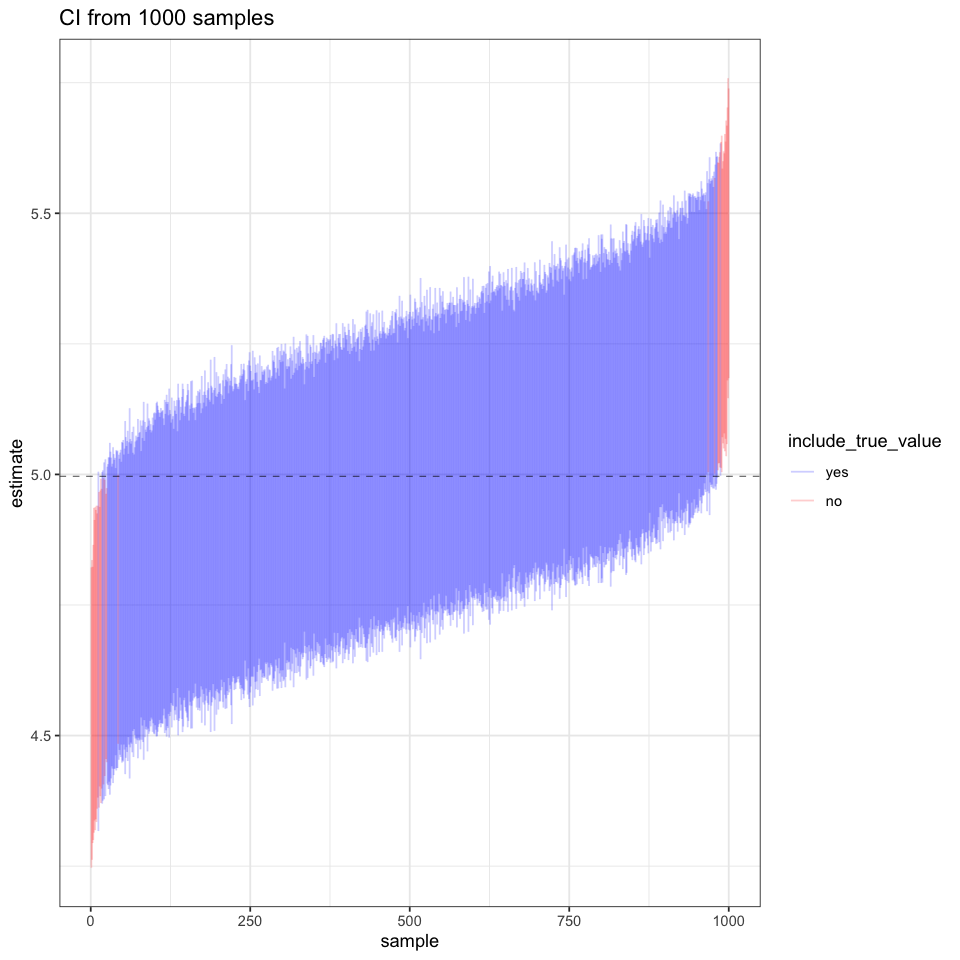

In [47]:
ggplot(dt, aes(x=seq, y=y, color=include_true_value)) + 
    geom_errorbar(aes(ymin=lower, ymax=upper), alpha=0.2, width=.1) + 
    theme_bw() + 
    scale_color_manual(values=c('yes'='blue','no'='red')) +
    labs(title='CI from 1000 samples', x='sample', y='estimate') + 
    geom_hline(yintercept=mean(y), color='black', linetype='dashed', size=0.2)

# What about a proportion?

The standard deviation for a proportion can be computed as: 

$\sigma= \sqrt{p(1-p)}$

In [48]:
# simulate from a binomial distribution
bm = rbinom(10000, 1, 0.3)
print(paste0('Standard deviation: ', round(sd(bm), 8)))

[1] "Standard deviation: 0.45983495"


In [49]:
prop.table(table(bm))
p = prop.table(table(bm))[2]
print(paste0('Standard deviation: ', round(sqrt(p*(1-p)), 8)))

bm
     0      1 
0.6964 0.3036 

[1] "Standard deviation: 0.45981196"


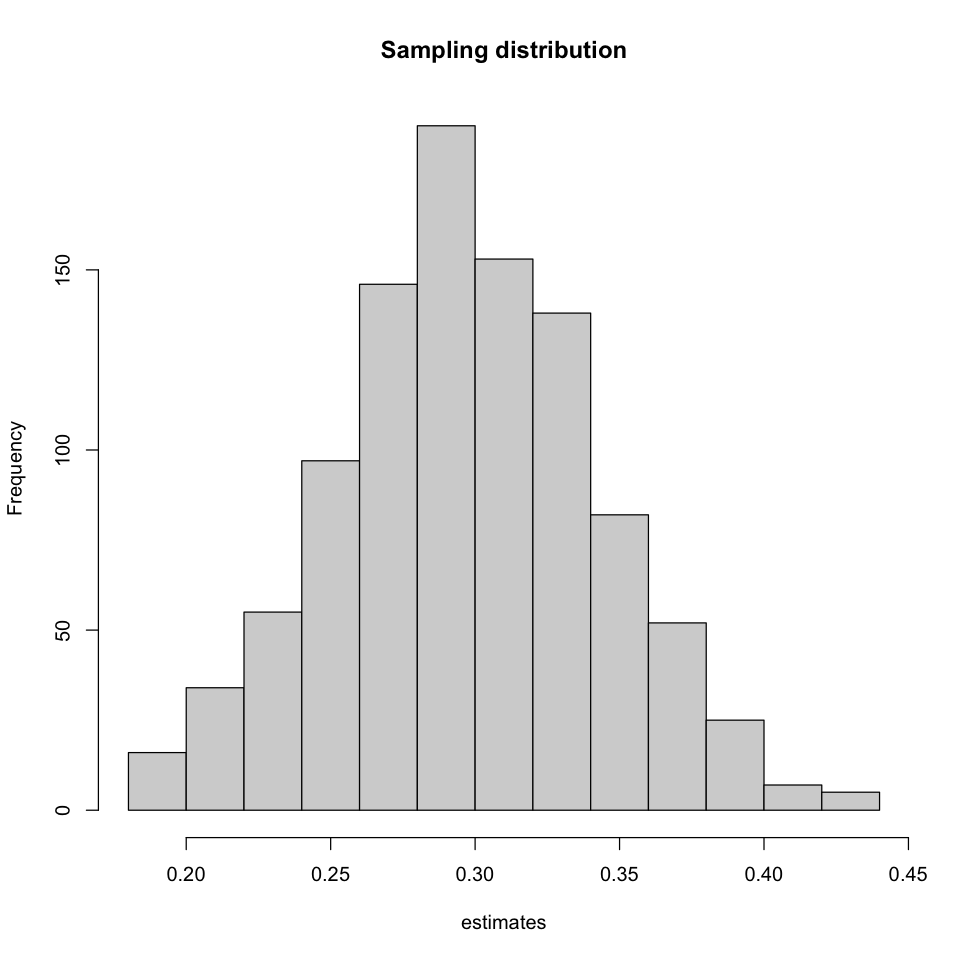

In [50]:
estimates = NULL
samples = list()
for (i in 1:1000) {
    samples[[i]] = sample(bm, 100)
    estimates = c(estimates, mean(samples[[i]]))
}

hist(estimates, main = 'Sampling distribution')

In [51]:
summary(estimates)
print(paste0('Standard error from sampling distribution: ', round(sd(estimates), 3)))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1800  0.2700  0.3000  0.3023  0.3300  0.4400 

[1] "Standard error from sampling distribution: 0.045"


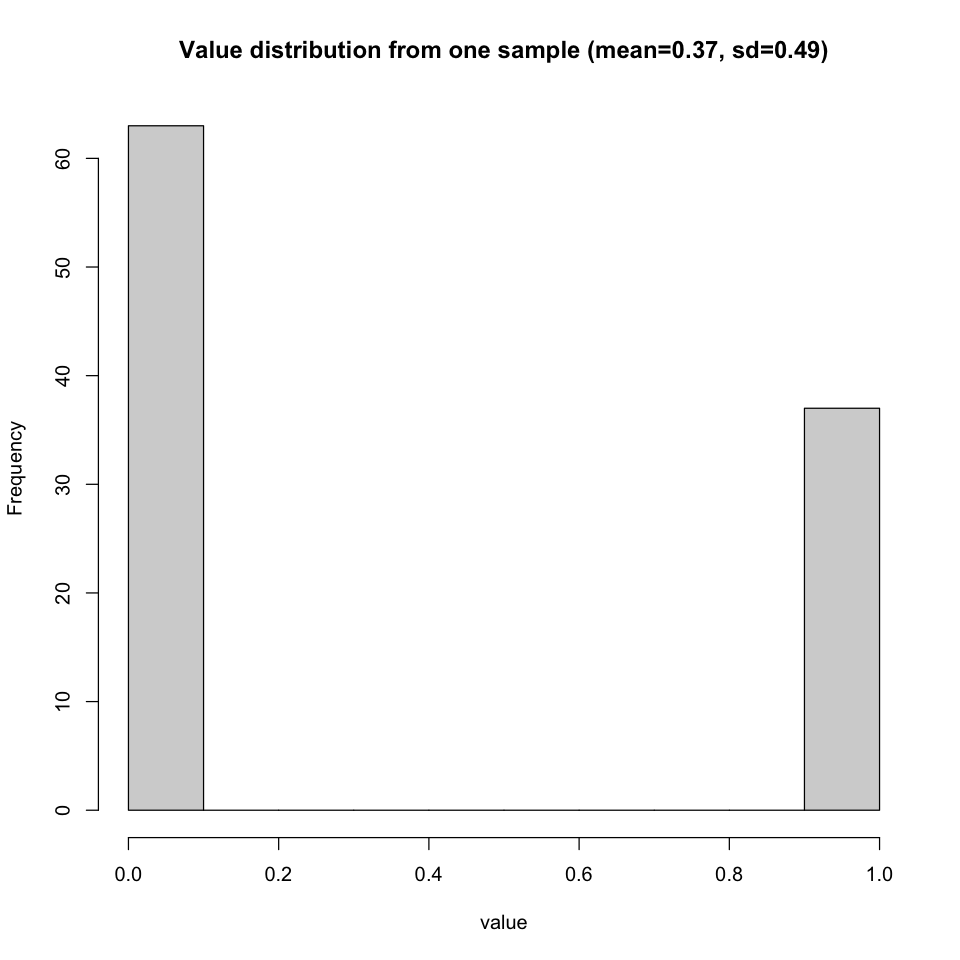

In [52]:
example = samples[[3]]
hist(example, 
    main=paste0('Value distribution from one sample (mean=', round(mean(example), 2), ', sd=', round(sd(example), 2), ')'), 
    xlab='value')

In [53]:
p = prop.table(table(example))[2]
print(paste0('Standard deviation: ', round(sqrt(p*(1-p)), 8)))

[1] "Standard deviation: 0.48280431"


In [54]:
print(paste0('Standard error from sample: ', 
    round( sqrt( p*(1-p)/length(example)), 8)))

[1] "Standard error from sample: 0.04828043"


In [55]:
dt = data.table()
for (i in seq_along(samples)) {
    sp = prop.table(table(samples[[i]]))[2]
    se  = sqrt(sp*(1-sp)/length(samples[[i]]))
    moe = z * se
    temp = data.table(p=sp, se=se, moe=moe, lower=sp-moe, upper=sp+moe)
    dt = rbind(dt, temp)
}

setorder(dt, p)
dt[, seq := 1:.N]
dt[, include_true_value := factor(ifelse(lower < mean(bm) & upper > mean(bm), 1, 0), labels=c('no', 'yes'))]
prop.table(table(dt$include_true_value))


   no   yes 
0.071 0.929 

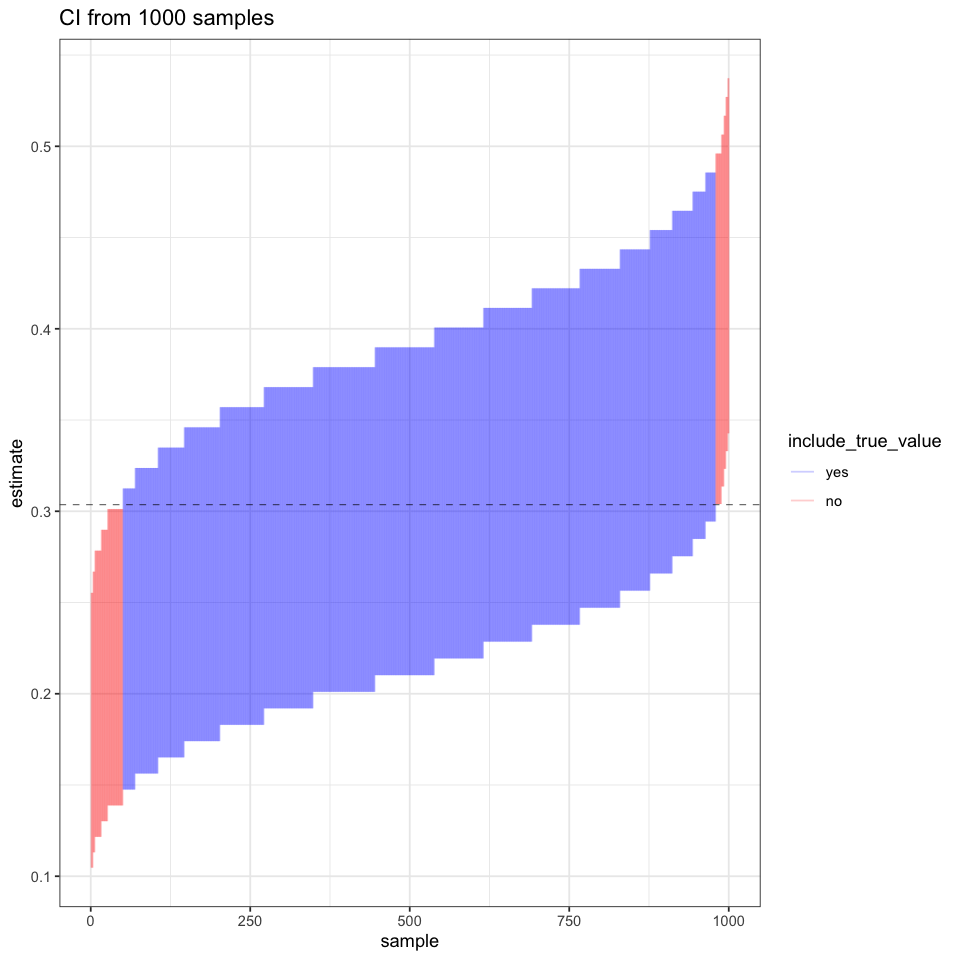

In [56]:
ggplot(dt, aes(x=seq, y=p, color=include_true_value)) + 
    geom_errorbar(aes(ymin=lower, ymax=upper), alpha=0.2, width=.1) + 
    theme_bw() + 
    scale_color_manual(values=c('yes'='blue','no'='red')) +
    labs(title='CI from 1000 samples', x='sample', y='estimate') + 
    geom_hline(yintercept=mean(bm), color='black', linetype='dashed', size=0.2)

# What about a count distribution (e.g., poisson)?

- In general used to model count data
- It creates some skewed distribution
- [See more details here](https://www.statology.org/poisson-distribution/)


In [57]:
ps = rpois(10000, 1.5)
summary(ps)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   1.000   1.514   2.000   8.000 

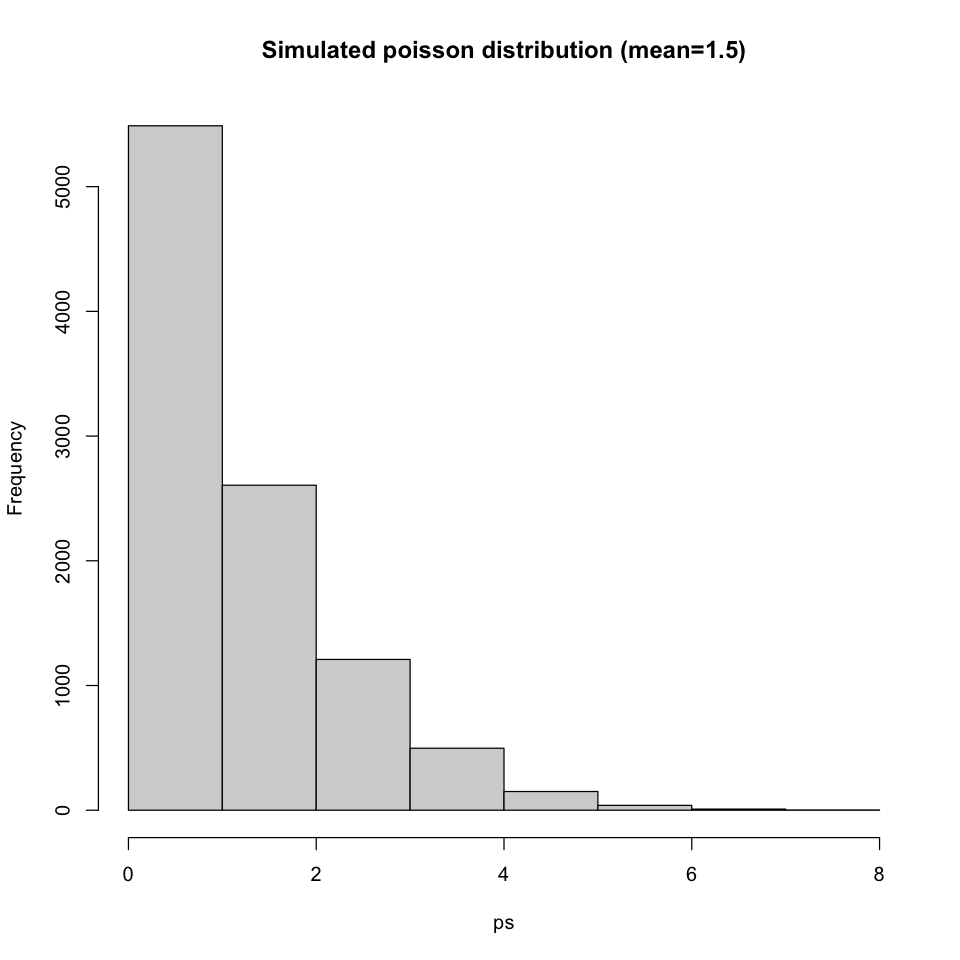

In [58]:
hist(ps, main = 'Simulated poisson distribution (mean=1.5)', breaks=9)

In [59]:
print(paste0('Standard deviation: ', round(sqrt(mean(ps)), 3)))

[1] "Standard deviation: 1.23"


## Let's create samples to see the strength of the central limit theorem

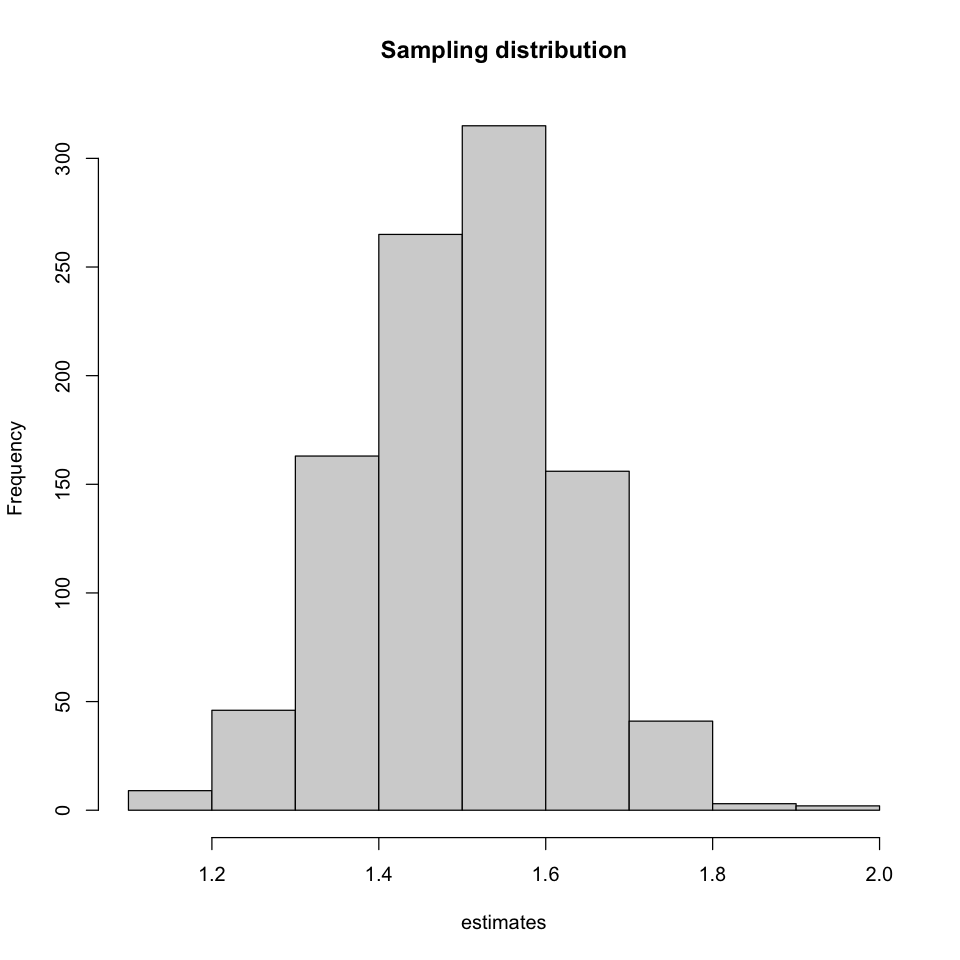

In [60]:
estimates = NULL
samples = list()
for (i in 1:1000) {
    samples[[i]] = sample(ps, 100)
    estimates = c(estimates, mean(samples[[i]]))
}

hist(estimates, main = 'Sampling distribution')

In [61]:
print(paste0('Standard error from sampling distribution: ', round(sqrt(mean(estimates)), 3)))

[1] "Standard error from sampling distribution: 1.226"


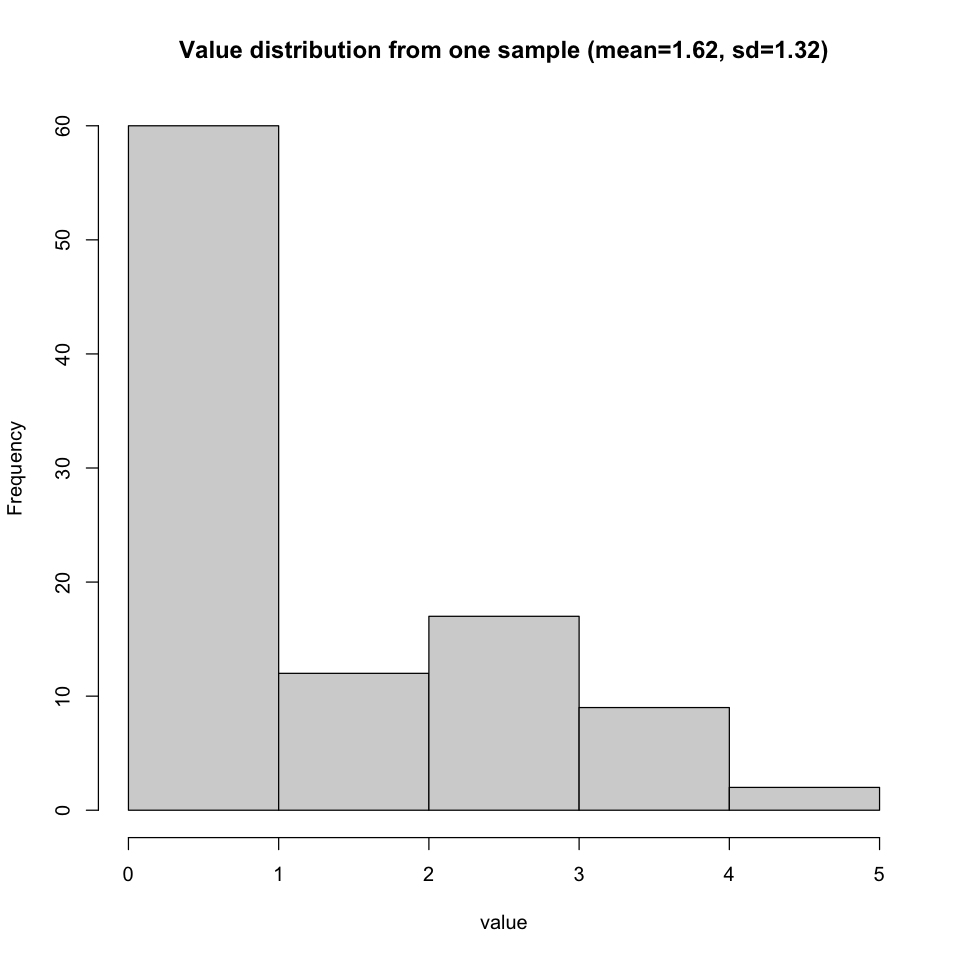

In [62]:
example = samples[[10]]
hist(example, 
    main=paste0('Value distribution from one sample (mean=', round(mean(example), 2), ', sd=', round(sd(example), 2), ')'), 
    xlab='value', breaks=5)

In [63]:
se  = sd(example) / sqrt(length(example))
print(paste0('Standard error from sample: ', round(se, 3)))

[1] "Standard error from sample: 0.132"


In [64]:
dt = data.table()
for (i in seq_along(samples)) {
    se  = sd(samples[[i]]) / sqrt(length(samples[[i]]))
    moe = z * se
    temp = data.table(y=mean(samples[[i]]), se=se, moe=moe, lower=mean(samples[[i]]) - moe, upper=mean(samples[[i]]) + moe)
    dt = rbind(dt, temp)
}

setorder(dt, y)
dt[, seq := 1:.N]
dt[, include_true_value := factor(ifelse(lower < mean(ps) & upper > mean(ps), 1, 0), labels=c('no', 'yes'))]
prop.table(table(dt$include_true_value))


   no   yes 
0.054 0.946 

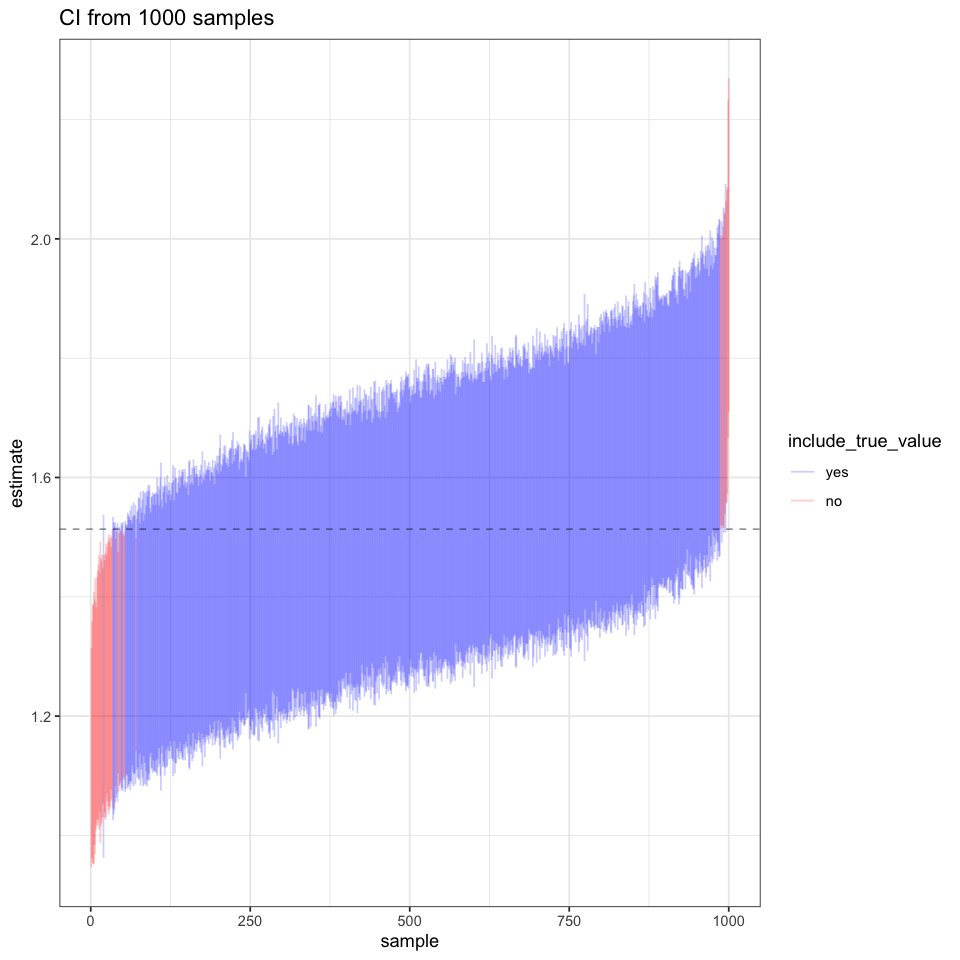

In [65]:
ggplot(dt, aes(x=seq, y=y, color=include_true_value)) + 
    geom_errorbar(aes(ymin=lower, ymax=upper), alpha=0.2, width=.1) + 
    theme_bw() + 
    scale_color_manual(values=c('yes'='blue','no'='red')) +
    labs(title='CI from 1000 samples', x='sample', y='estimate') + 
    geom_hline(yintercept=mean(ps), color='black', linetype='dashed', size=0.2)

# If we want to estimate a tiny proportion... 

In [66]:
# simulate from a binomial distribution
bm = rbinom(100000, 1, 0.05)
summary(bm)
print(paste0('Standard deviation: ', round(sd(bm), 8)))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.04905 0.00000 1.00000 

[1] "Standard deviation: 0.21597353"


In [67]:
p = prop.table(table(bm))[2]
print(paste0('Standard deviation population: ', round(sqrt(p*(1-p)), 8)))

[1] "Standard deviation population: 0.21597245"


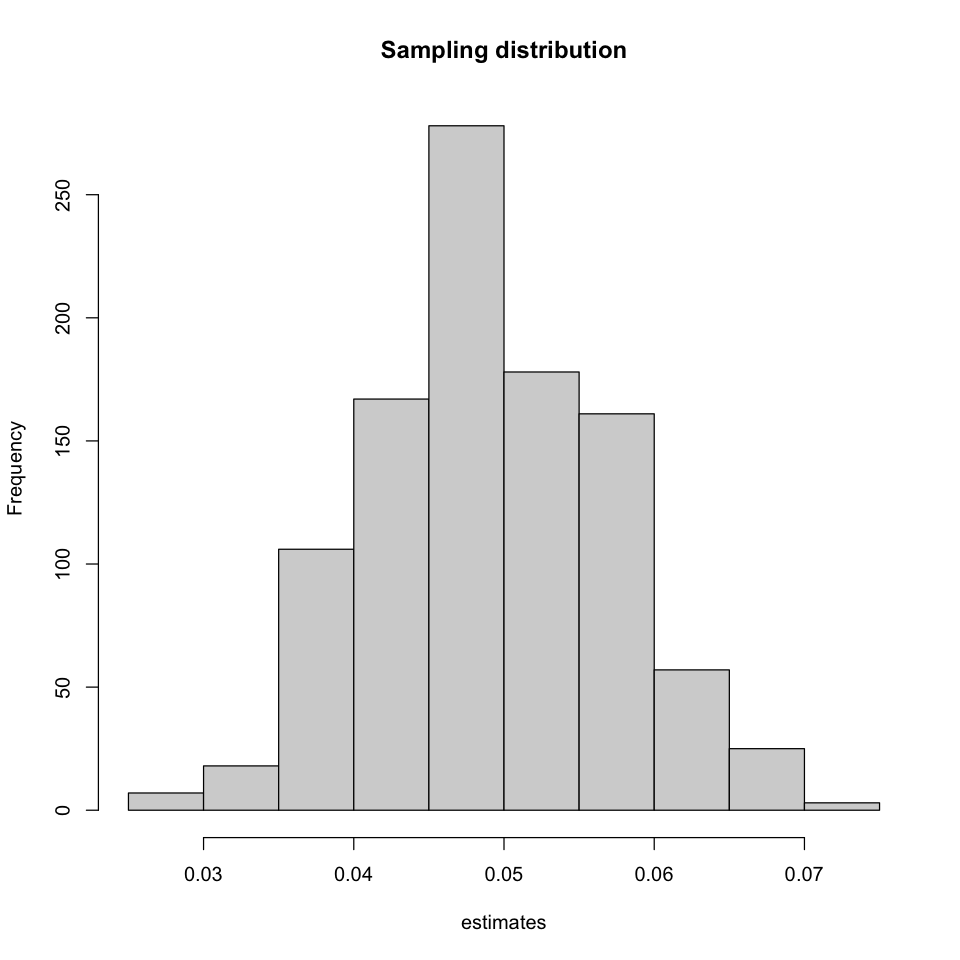

In [68]:
estimates = NULL
samples = list()
for (i in 1:1000) {
    samples[[i]] = sample(bm, 700)
    estimates = c(estimates, mean(samples[[i]]))
}

hist(estimates, main = 'Sampling distribution')

In [69]:
dt = data.table()
for (i in seq_along(samples)) {
    se  = sd(samples[[i]]) / sqrt(length(samples[[i]]))
    moe = z * se
    temp = data.table(y=mean(samples[[i]]), se=se, moe=moe, lower=mean(samples[[i]]) - moe, upper=mean(samples[[i]]) + moe)
    dt = rbind(dt, temp)
}

setorder(dt, y)
dt[, seq := 1:.N]
dt[, include_true_value := ifelse(lower < p & upper > p, 1, 0)]
dt[, include_true_value := ifelse(y==0, 0, include_true_value)]
dt[, include_true_value := factor(include_true_value, labels=c('no', 'yes'))]
prop.table(table(dt[se!=0]$include_true_value))


   no   yes 
0.036 0.964 

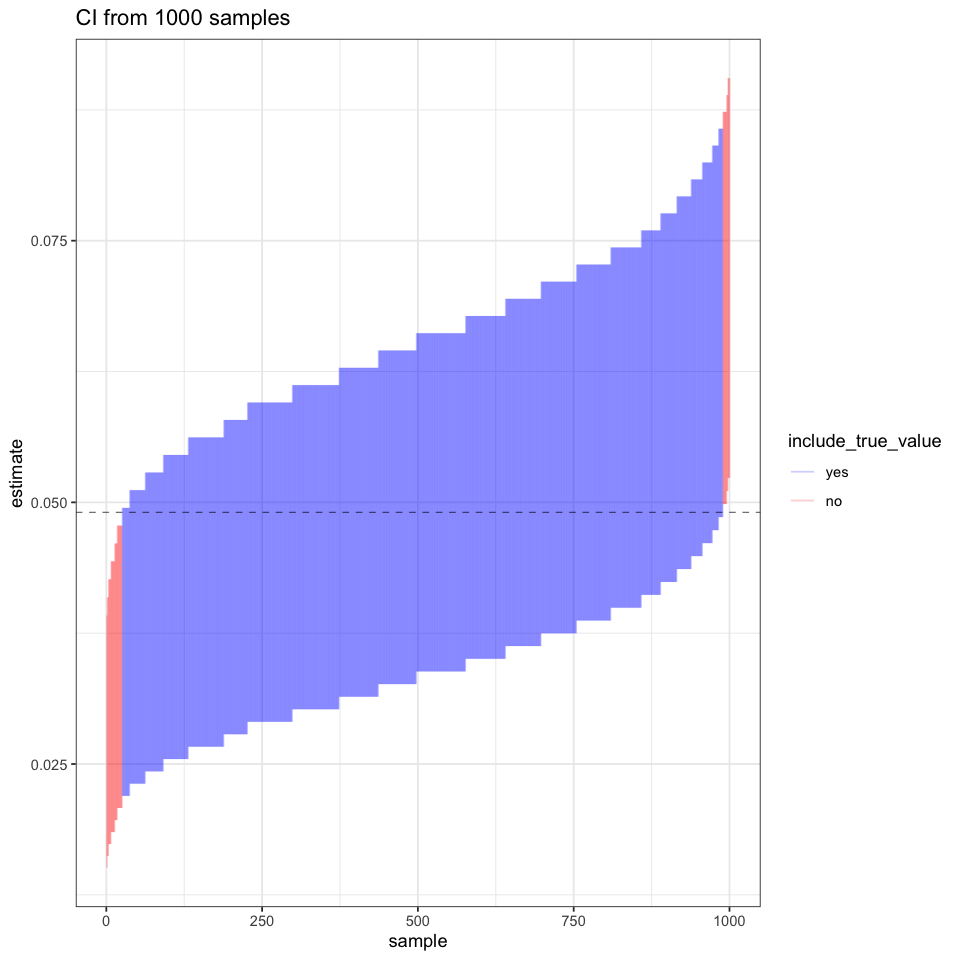

In [70]:
ggplot(dt[se!=0], aes(x=seq, y=y, color=include_true_value)) + 
    geom_errorbar(aes(ymin=lower, ymax=upper), alpha=0.2, width=.1) + 
    theme_bw() + 
    scale_color_manual(values=c('yes'='blue','no'='red')) +
    labs(title='CI from 1000 samples', x='sample', y='estimate') + 
    geom_hline(yintercept=p, color='black', linetype='dashed', size=0.2)